In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import NearestNeighbors
from mrmr import mrmr_regression

# Quiet setting warnings
pd.options.mode.chained_assignment = None

# Study Summary

The National Institutes of Health funded a study to analyze what factors may predict the survival time after diagnosis of a terminal type of liver cancer. 2,500 patients were enrolled in ten different U.S. hospital and each patient underwent a biopsy that provided a measurement of twenty quantitative cell measurements. The overall goal of this study is to identify which cell measurements (if any) may be predictors of the survival time in addition to basic patient demographic information.

**NOTE**: The focus at this point in the course was on the correct use of linear regression in real world situations (i.e., predictors are rarely linearly related with the outcome, esp. in biomedical data). Therefore, there is not an emphasis on CV or generalizability in this assignment.

In [2]:
# Import data
WORK_DIR = os.getcwd()
filename = 'CancerSurvivalData.xlsx'
data = pd.read_excel(f'{WORK_DIR}/{filename}')
data.head(5)

,Age (years),Sex,Racial group,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
0,68.475758,Female,Hispanic or Latino,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,...,66.071899,-25.324697,-20.617584,-12.444847,20.939882,6.009270,37.900230,17.272812,0.024656,11.508051
1,73.986450,Female,White,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,...,69.831818,-27.426292,-27.363832,-4.045206,22.637911,2.613145,41.289307,18.726410,2.884620,9.522676
2,70.285954,Male,White,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,...,61.370747,-25.570925,-26.268887,-4.757288,22.608706,0.150276,41.231022,17.960768,2.642166,8.472567
3,46.744625,Female,White,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,...,65.829353,-27.222082,-27.243317,-9.449100,22.249207,-5.450154,40.513496,19.318758,1.044667,5.196368
4,71.733703,Male,White,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,...,68.680405,-28.357386,-27.913317,-9.928357,32.855518,-1.246710,42.646397,17.513947,0.881487,11.254032


# Supplementary Functions

Functions used throughout this report are defined below to improve interpretability of the rest of the report.

In [3]:
def xy_split(df, target: str, to_numpy: bool):
    '''
    Function to split df into features (x) and target (y)
    
    Input
    - target: string corresponding to the target column name
    - to_numpy: boolean flag that can be used to convert x and y outputs to numpy arrays
    '''
    
    # Split data frame
    x = df.loc[:, df.columns != target]
    y = df.loc[:, target]
    
    # Return x, y in specified format
    return (x.to_numpy(), y.to_numpy()) if to_numpy else (x, y)


def num_feature_dist_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('seaborn-v0_8-white')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(
        n_row, n_col, figsize=(fig_width, fig_height), gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions
    for i, feature in enumerate(numeric_features):
        sns.histplot(data=df, x=feature, ax=plots[i], bins=20, edgecolor="white")
        plots[i].set_title(feature, fontsize=11)
        plots[i].set_xlabel('')
        if i % n_col:
            plots[i].set_ylabel('')
    
    # Display full figure 
    plt.show()
        

def cat_feature_count_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each categorical feature in a data frame
    '''

    # Extract features to plot - only non-numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    nonnumeric_features = [feature for feature in df.columns if feature not in numeric_features]
    
    # Set figure space
    plt.style.use('seaborn-v0_8-white')
    n_row = int(np.ceil(len(nonnumeric_features)/n_col))
    fig, axs = plt.subplots(
        n_row, n_col, figsize=(fig_width, fig_height), gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions
    for i, feature in enumerate(nonnumeric_features):
        
        # Set count df for plot
        labels = list(set(df[feature]))
        counts = [list(df[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({
            'labels': [label if label is not np.nan else "Missing" for label in labels], 
            'counts': counts})
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color='tab:blue')
        plots[i].set_title(feature, fontsize=11)
        plots[i].set_ylabel('')
        
    # Display full figure
    plt.show()
    

def resid_plot(df, features, y, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''
    
    # Set figure space
    plt.style.use('seaborn-v0_8-white')
    n_row = int(np.ceil(len(features)/n_col))
    fig, axs = plt.subplots(
        n_row, n_col, figsize=(fig_width, fig_height), gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)
    
    # Plot residual vs each figure in separate subplots
    for i, feature in enumerate(features):
        sns.residplot(
            data=df, x=feature, y=y, ax=plots[i], lowess=True, scatter_kws={'alpha': 0.1}, line_kws={'color': 'r'})
        plots[i].set_title(feature, fontsize=11)
        plots[i].set_xlabel('')
        if i % n_col:
            plots[i].set_ylabel('')
        else:
            plots[i].set_ylabel('Residual')
    
    # Display full figure
    plt.show()

    
def r2_adj_score(y, y_pred, n, k):
    return 1 - ((1-r2_score(y, y_pred))*(n-1)/(n-k-1))

# EDA

## Missing Values

In [4]:
# Determine number of missing values in each column
data.isnull().sum()

Age (years)                0
Sex                        0
Racial group             237
Cell profile 0            25
Cell profile 1             0
Cell profile 2             0
Cell profile 3             0
Cell profile 4             0
Cell profile 5            25
Cell profile 6            25
Cell profile 7            25
Cell profile 8             0
Cell profile 9             0
Cell profile 10            0
Cell profile 11            0
Cell profile 12            0
Cell profile 13            0
Cell profile 14            0
Cell profile 15            0
Cell profile 16            0
Cell profile 17            0
Cell profile 18            0
Cell profile 19            0
Survival time (years)      0
dtype: int64

## Distributions

### Target Distribution
Our target variable is survival time. The Shapiro test for normality returns a p-value of 0.26, which suggests that the distribution of our target variable is approximately normally distributed (at least we can't reject the hypothesis that it is normally distributed). Outliers seem minimal.

In [5]:
# Split df into target/features
target = 'Survival time (years)'
x, y = xy_split(df=data, target='Survival time (years)', to_numpy=False)

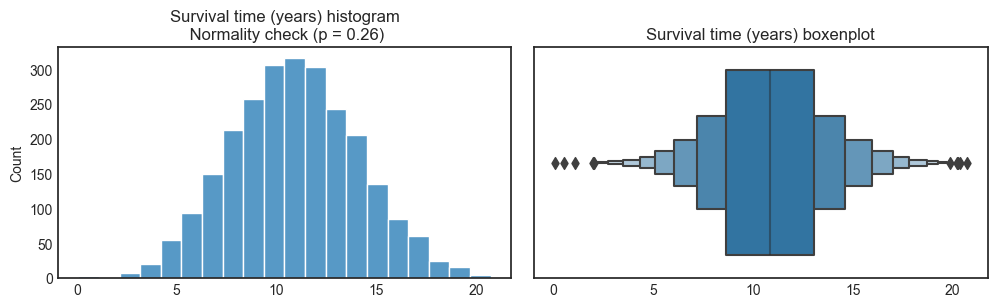

In [6]:
# Set figure space
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={"hspace": 0, "wspace": 0.05})

# Test for normality
test_stat, p = scipy.stats.shapiro(data[target])

# Plot, left side
sns.histplot(data=data, x=target, ax=ax[0], bins=20, edgecolor="white")
ax[0].set_title(f'{target} histogram\n Normality check (p = {round(p, 2)})', fontsize=12)
ax[0].set_xlabel('')

# Plot, right side
sns.boxenplot(data=data, x=target, ax=ax[1])
ax[1].set_title(f'{target} boxenplot', fontsize=12)
ax[1].set_xlabel('')
plt.show()

### Numeric Feature Distribution

The plots below show the distributions of numeric features in the data set. From the visualization we can see that most cell profile data are approximately normally distributed. Age is clearly not normally distributed, but roughly uniformly distributed. Fliers/potential outliers are noticeable from these visuals as well. None of the fliers/outliers seem like entry errors, so we will likely opt to leave these values in the data set during modeling.


Numerical Feature Distributions:



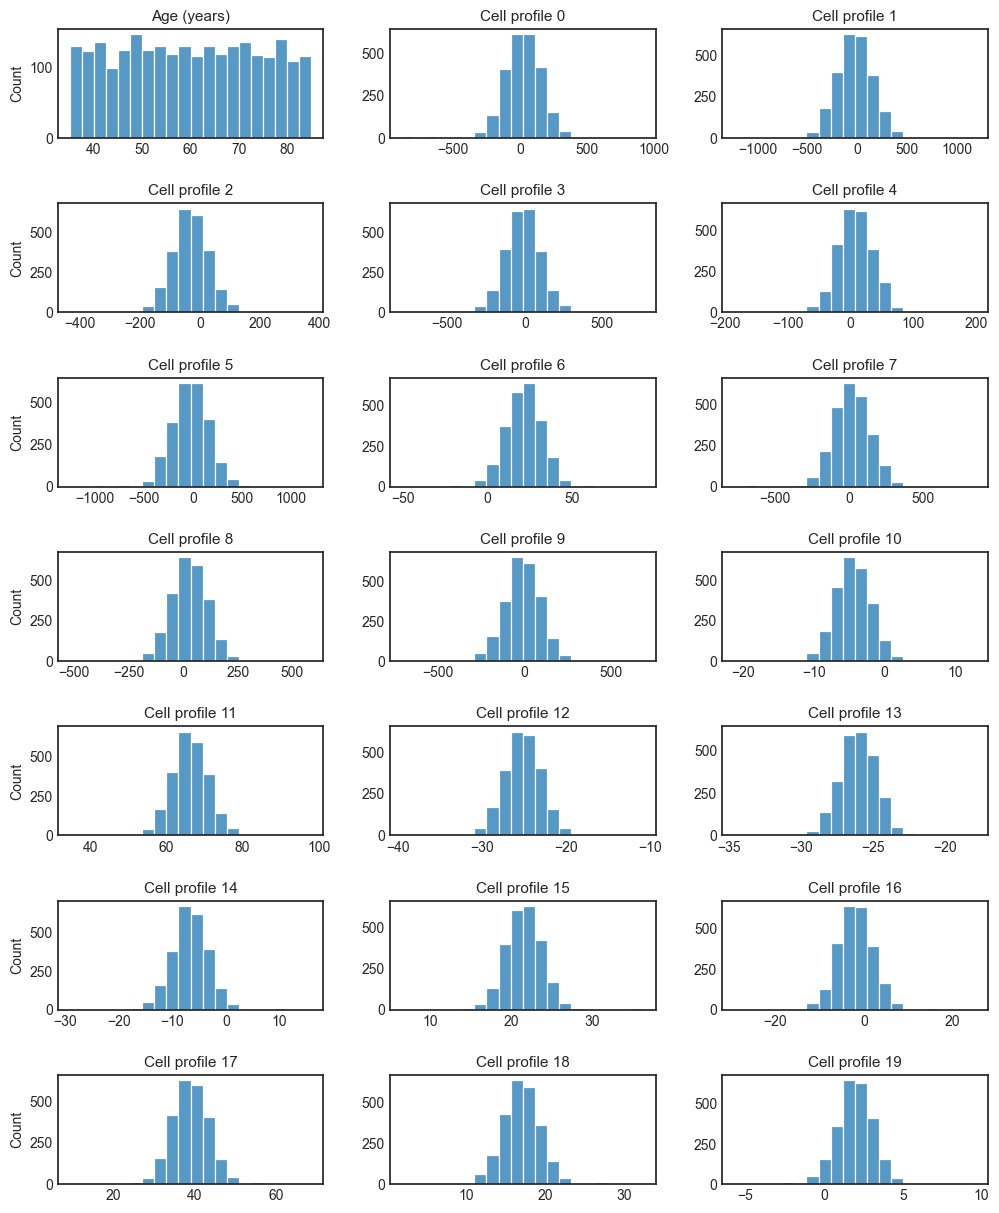

In [7]:
# Plot numeric feature distributions
print('\nNumerical Feature Distributions:\n')
num_feature_dist_plot(df=x, n_col=3, fig_width=12, fig_height=15, hspace=0.6, wspace=0.25)

### Categorical Feature Class Balance

**NOTE:** Heavy class imblance exists among racial groups, with white individuals representing the majority group. White subjects do tend to have shorter survival times than subjects in alternative groups. There is an argument to be made that we could preserve this information and balance the groups by creating two new racial groups (white and non-white). We should, however, be careful with using race in this context (depending on the use of the model). If, for example, the model is to be used for making important medical decisions (e.g. eligibility for a medical procedure), we should consider removing racial group from the feature set. I will be cautious in my approach here and omit the racial grouping feature in our model. If we did decide to impute missing values for race we could use something like missForest.


Categorical Feature Class Balance:



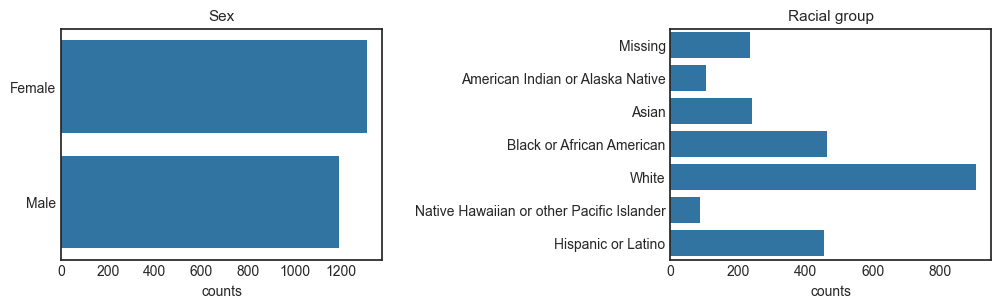

In [8]:
# Plot non-numeric feature distributions
print('\nCategorical Feature Class Balance:\n')
cat_feature_count_plot(df=x, n_col=2, fig_width=12, fig_height=3, hspace=0.6, wspace=0.9)

<AxesSubplot: xlabel='Survival time (years)', ylabel='Racial group'>

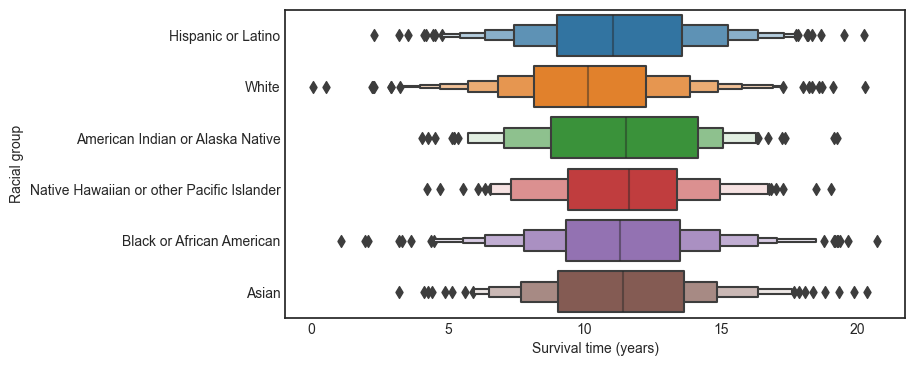

In [9]:
# Checking survival time by racial group
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxenplot(x=target, y='Racial group', data=data)

In [10]:
# Encode sex variable and drop racial group
binarizer = LabelBinarizer()
x['Sex'] = binarizer.fit_transform(x['Sex'])
x.drop(['Racial group'], axis=1, inplace=True)
x.head(5)

,Age (years),Sex,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,...,Cell profile 10,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19
0,68.475758,0,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,263.818563,...,-5.097365,66.071899,-25.324697,-20.617584,-12.444847,20.939882,6.009270,37.900230,17.272812,0.024656
1,73.986450,0,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,159.291946,...,-3.143062,69.831818,-27.426292,-27.363832,-4.045206,22.637911,2.613145,41.289307,18.726410,2.884620
2,70.285954,1,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,83.489261,...,-3.176673,61.370747,-25.570925,-26.268887,-4.757288,22.608706,0.150276,41.231022,17.960768,2.642166
3,46.744625,0,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,-88.881909,...,-3.590431,65.829353,-27.222082,-27.243317,-9.449100,22.249207,-5.450154,40.513496,19.318758,1.044667
4,71.733703,1,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,40.492528,...,-2.360501,68.680405,-28.357386,-27.913317,-9.928357,32.855518,-1.246710,42.646397,17.513947,0.881487


## Relationships Between Predictors and Outcome
### Age vs Survival Time

The relationship between the outcome and age appears to be non-linear. There may be evidence of a logarithmic relationship here. I'm going to log-transform this feature and check for linearity in the residuals.

[None]

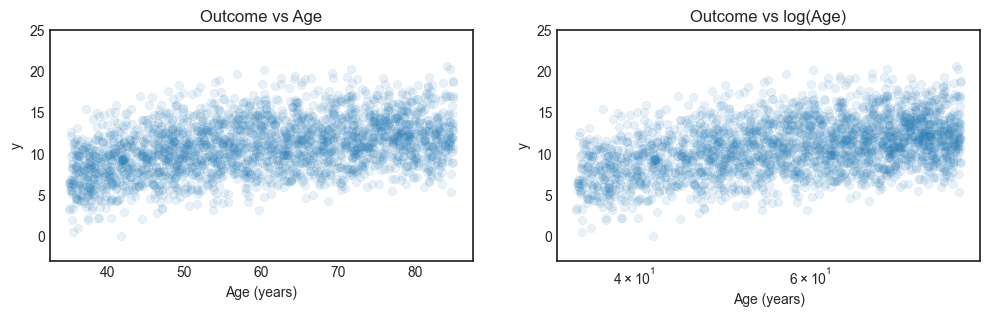

In [11]:
# Set figure space
plt.style.use('seaborn-v0_8-white')
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Age vs outcome
sns.scatterplot(x='Age (years)', y='Survival time (years)', data=data, ax=axs[0], alpha=0.1, edgecolor=None)
axs[0].set_title('Outcome vs Age')
axs[0].set_ylabel('y')
axs[0].set_ylim(-3, 25)

# log(Age) vs outcome
sns.scatterplot(x='Age (years)', y='Survival time (years)', data=data, ax=axs[1], alpha=0.1, edgecolor=None)
axs[1].set_title('Outcome vs log(Age)')
axs[1].set_ylabel('y')
axs[1].set_ylim(-3, 25)
axs[1].set(xscale="log")

In [12]:
x['Age (years)'] = np.log(x['Age (years)'])

### Cell Profiles vs Survival Time
We can see that some cell profiles have interesting associations with survival time (e.g. cell profiles 2, 3, and 4). We will pay attention to the residuals of these from the OLS regression, with the expectation to use non-linear techniques for these features (i.e. higher-order polynomial terms).

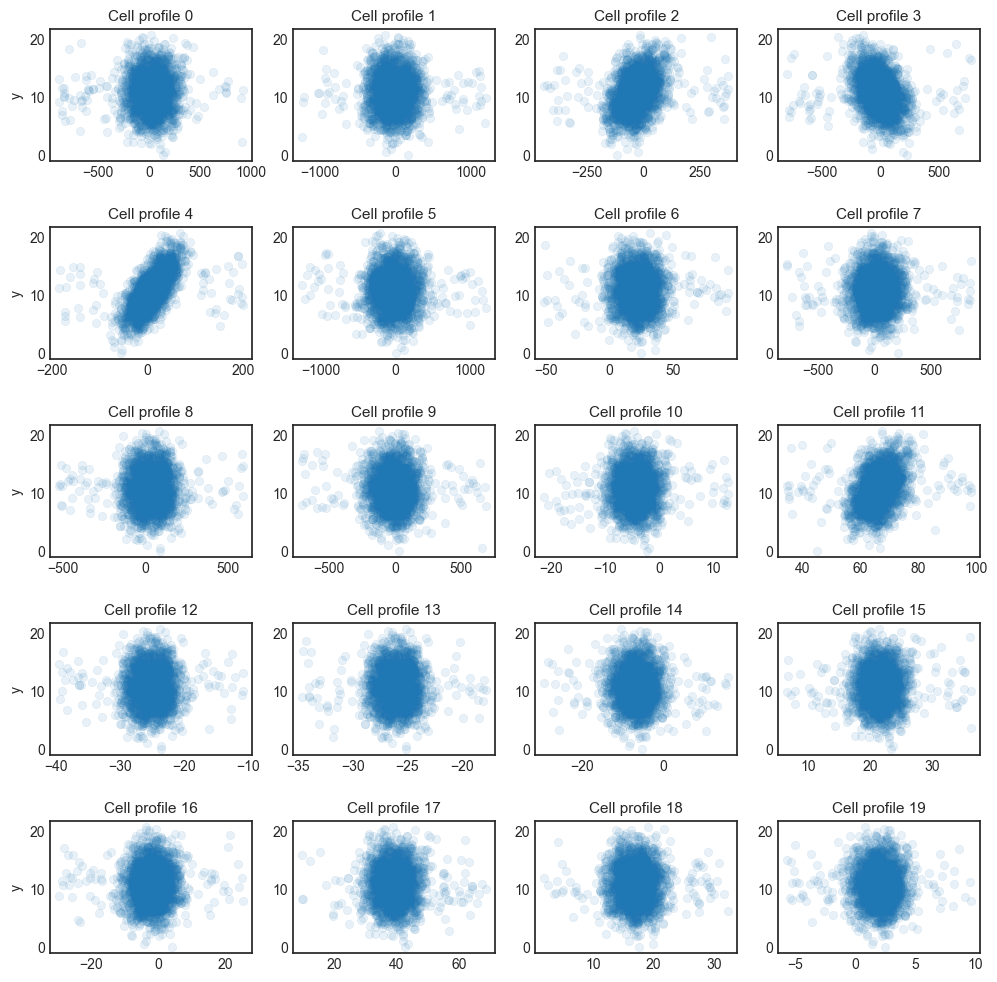

In [13]:
cellProfiles = [feature for feature in x.columns if feature not in ['Age (years)', 'Sex']]

# Set figure space
plt.style.use('seaborn-v0_8-white')
fig, axs = plt.subplots(5, 4, figsize=(12, 12), gridspec_kw={"hspace": 0.5, "wspace": 0.2})
plots = []
for ax in axs:
    for plot in ax:
        plots.append(plot)
        
# Scatter plots
for i, feature in enumerate(cellProfiles):
    sns.scatterplot(x=feature, y='Survival time (years)', data=data, ax=plots[i], alpha=0.1, edgecolor=None)
    plots[i].set_title(feature, fontsize=11)
    plots[i].set_xlabel('')
    if i % 4:
        plots[i].set_ylabel('')
    else:
        plots[i].set_ylabel('y')

# Missing Data Imputation
## Cell Profile Imputation Using Simple Imputation

Cell profile features are continuous. We can implement a simple imputation method to fill in these missing values. I'm going to opt for median imputation since outliers/fliers are apparent in the cell profile distribution plots.

In [14]:
# Determine columns to impute values in
impute_cols = x.columns[x.isnull().any()].tolist()

# Median imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for feature in impute_cols:
    x[feature] = imputer.fit_transform(x[feature].values.reshape(-1, 1))[:,0]
    
# Check that there are no missing values in imputed columns
x.isnull().sum()

Age (years)        0
Sex                0
Cell profile 0     0
Cell profile 1     0
Cell profile 2     0
Cell profile 3     0
Cell profile 4     0
Cell profile 5     0
Cell profile 6     0
Cell profile 7     0
Cell profile 8     0
Cell profile 9     0
Cell profile 10    0
Cell profile 11    0
Cell profile 12    0
Cell profile 13    0
Cell profile 14    0
Cell profile 15    0
Cell profile 16    0
Cell profile 17    0
Cell profile 18    0
Cell profile 19    0
dtype: int64

# Multicollinearity Assessment
## Correlation Plot
From the correlation plot below, it is apparent that some cell profiles are somewhat correlated (pearson correlation coefficients ~0.60). Interestingly, cell profiles 0-9 show little collinearity between eachother. We should consider regularization to limit the effects of multicollinearity, although regularization techniques tend to choose collinear predictors non-deterministically (i.e. there is some randomness to which predictor the model will choose).

Text(0.5, 1.0, 'Correlation Plot of Numeric Features')

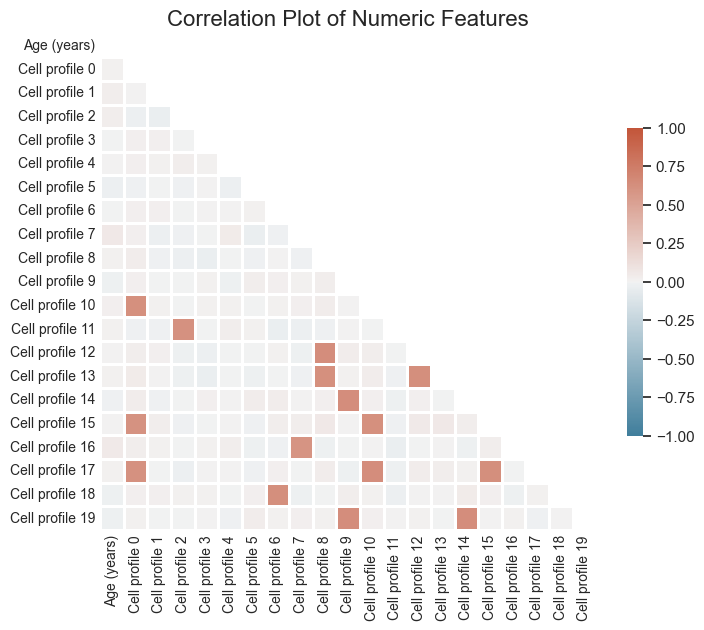

In [15]:
# Extract numeric features
x_corr = x.copy()
x_corr.drop('Sex', axis=1, inplace=True)

# Source for correlation plot: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = x_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=1, cbar_kws={"shrink": .5})
ax.set_title('Correlation Plot of Numeric Features', size=16)

## Variance Inflation Factor Check

The general rule of thumb is that a VIF > 5 might suggest collinearity. Interestingly, none of the VIFs below approach this. I'll rely on other techniques for feature selection (maybe the LASSO or mRMR).

In [16]:
# Implementation source: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
x_vif = sm.add_constant(x_corr) # Add constant term
pd.Series([variance_inflation_factor(x_vif.values, i) for i in range(x_vif.shape[1])], index=x_vif.columns)

const              1272.931513
Age (years)           1.008104
Cell profile 0        1.999048
Cell profile 1        1.008696
Cell profile 2        1.606506
Cell profile 3        1.003857
Cell profile 4        1.005902
Cell profile 5        1.006086
Cell profile 6        1.657492
Cell profile 7        1.562878
Cell profile 8        1.948599
Cell profile 9        1.996483
Cell profile 10       2.130323
Cell profile 11       1.604933
Cell profile 12       2.003322
Cell profile 13       1.925139
Cell profile 14       1.987250
Cell profile 15       2.057805
Cell profile 16       1.562863
Cell profile 17       2.136031
Cell profile 18       1.659055
Cell profile 19       1.983496
dtype: float64

# Feature Scaling (Standardization)
Prior to fitting the OLS regression model we will standardize the data. This should be useful since our features are mostly normally distributed (although age is not) and linear regression assumes normality. Standardization is robust to outliers that may be present.

In [17]:
# Standardize numeric features
x_DF = x.copy()
numFeatures = [feature for feature in x.columns if feature not in ['Sex']]
scaler = StandardScaler()
x[numFeatures] = scaler.fit_transform(x[numFeatures])
x.head(5)

,Age (years),Sex,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,...,Cell profile 10,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19
0,0.664278,0,-0.158217,-1.017288,-0.027965,-1.525878,-1.200674,-0.177085,0.109791,1.641403,...,-0.205545,-0.010346,-0.050100,3.520220,-1.438363,-0.213437,1.644792,-0.244986,0.089898,-1.400281
1,0.973428,0,0.465488,-0.638853,0.612395,4.486851,-0.619981,-0.926268,0.639015,0.942908,...,0.428831,0.635648,-0.854547,-0.843517,0.665444,0.419268,0.950682,0.402422,0.619884,0.696580
2,0.768492,1,0.454761,-0.851144,-0.828629,-1.210008,-1.089198,-0.068787,0.360261,0.436359,...,0.417920,-0.818056,-0.144350,-0.135263,0.487093,0.408386,0.447314,0.391288,0.340729,0.518818
3,-0.860581,0,0.322712,0.013303,-0.069274,0.708043,-3.347861,-0.408577,0.854675,-0.715505,...,0.283613,-0.052019,-0.776380,-0.765562,-0.688037,0.274432,-0.697318,0.254221,0.835856,-0.652432
4,0.849926,1,0.715238,0.134538,0.416296,0.523945,0.234297,-0.150843,0.197583,0.149035,...,0.682853,0.437823,-1.210951,-1.198944,-0.808073,4.226466,0.161794,0.661664,0.177817,-0.772072


# Feature Selection

Here we will use mRMR for feature selection. This should help reduce multicollinearity. This package returns an list of features ordered by importance. We can use an iterative process of feature removal to see which set of features returns the best adjusted R-squared when used in a simple OLS model. This should give us a useful set of cell profile measurements for predicting survival time. We include age and sex in the feature selection process since we include these as precision variables in downstream models.

**NOTE**: We could have used something like backward stepwise selection or LASSO but I wanted to try out this algorithm

In [18]:
# Feature selection with mrmr
feature_importance = mrmr_regression(X=x, y=y, K=22)
feature_importance.remove('Age (years)')
feature_importance.remove('Sex')

100%|███████████████████████████████████████████| 22/22 [00:03<00:00,  7.12it/s]


In [19]:
# Lists to store results
cellProfileCount = []
r2_scores = []

# Copy y and convert to numpy
y_featureSelect = y.to_numpy()

# Iterate through k best features
for i in range(1, 21):
    cellProfileCount.append(i)
    cellProfiles = feature_importance[0:i]
    featureSet = x[['Age (years)', 'Sex'] + cellProfiles].to_numpy()
    featureSet = sm.add_constant(featureSet)
    model = sm.OLS(y_featureSelect, featureSet).fit()
    r2_scores.append(round(model.rsquared_adj, 3))
    
# Store all results in data frame
top_k_features_DF = pd.DataFrame({'top_k_features': cellProfileCount, 'r2_adj_score': r2_scores})
top_k_features_DF.head(10)

,top_k_features,r2_adj_score
0,1,0.536
1,2,0.606
2,3,0.678
3,4,0.694
4,5,0.695
5,6,0.695
6,7,0.695
7,8,0.695
8,9,0.695
9,10,0.695


Text(0.5, 0, 'Top k Features Included in Model')

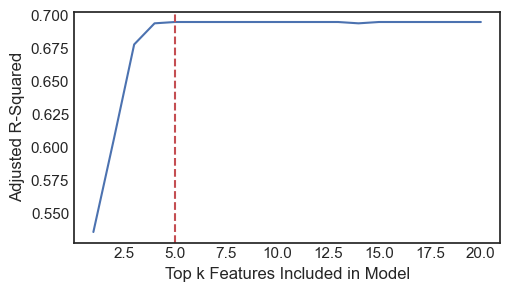

In [20]:
# Set figure space
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3))

# Line plot
sns.lineplot(data=top_k_features_DF, x='top_k_features', y='r2_adj_score')
ax.axvline(x=5, c='r', linestyle='--')
ax.set_ylabel('Adjusted R-Squared')
ax.set_xlabel('Top k Features Included in Model')

It appears that the optimal balance of max adjusted $R^2$ and parsimony occurs when using the top 5 cell profiles selected by mRMR. That is, model fit does not improve when including additional cell profiles. We'll move forward with this cell profile set.

In [21]:
selected_features = ['Age (years)', 'Sex'] + feature_importance[0:5]
x_DF = x[selected_features]

# Modeling

In [22]:
# Prepare features and target for modeling
x = x_DF.to_numpy()
y = y.to_numpy()

## OLS Model

First we will fit a simple OLS model and evaluate the diagnostics (residuals). We don't expect this model to be perfect. For example, some features may have a non-linear relationship with the outcome. We expect to use the information from this model to fit a more appropriate non-linear (polynomial) regression model.

In [23]:
# State variables in terms of x1, x2, x3... - want to pull directly from data set
model_varnames = [f'x{i+1}' for i in range(0, len(x_DF.columns))]
varnames = x_DF.loc[:, x_DF.columns != 'Survival time (years)'].columns
varname_dict = dict(zip(model_varnames, varnames))
for key, value in varname_dict.items():
    print(f'{key}: {value}')

x1: Age (years)
x2: Sex
x3: Cell profile 4
x4: Cell profile 3
x5: Cell profile 11
x6: Cell profile 2
x7: Cell profile 10


In [24]:
# Fit model and display results
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     814.0
Date:                Wed, 04 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:41:41   Log-Likelihood:                -4972.2
No. Observations:                2500   AIC:                             9960.
Df Residuals:                    2492   BIC:                         1.001e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4694      0.049    234.164      0.000      11.373      11.565
x1             1.3224      0.035     37.310      0.000       1.253       1.392
x2            -1.2032      0.071    -16.958      0.000      -1.342      -1.064
x3             1.7904      0.035     50.508      0.000       1.721       1.860
x4            -0.8405      0.035    -23.719      0.000      -0.910      -0.771
x5             0.5428      0.045     12.129      0.000       0.455       0.631
x6             0.5211      0.045     11.643      0.000       0.433       0.609
x7             0.0745      0.035      2.103      0.036       0.005       0.144
==============================================================================
Omnibus:                      493.490   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14105.855
Skew:                          -0.144   Prob(JB):                         0.00
Kurtosis:                      14.633   Cond. No.                         2.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## OLS Regression Model Diagnostics

### Performance Metrics

In [25]:
# Set up output data frame to contain clean data, y, predictions and residuals
results_DF = x_DF
results_DF['y'] = y

# Use full set to get predictions and residuals
predictions = model.predict(x)
results_DF['y_pred'] = model.predict(x)
results_DF['residual'] = model.resid

# Performance metrics
print(f'MAE: {round(mean_absolute_error(y, predictions), 2)}')
print(f'MSE: {round(mean_squared_error(y, predictions), 2)}')
print(f'R-squared: {round(r2_score(y, predictions), 3)}')
print(f'Adjusted R-squared: {round(model.rsquared_adj, 3)}')

MAE: 1.16
MSE: 3.13
R-squared: 0.696
Adjusted R-squared: 0.695


### Residuals vs Predicted Outcome

The residuals appear to be normally distributed, but there is a clear bias that exists. We'll check the residuals as a function of age and cell profiles to determine what could be causing this.

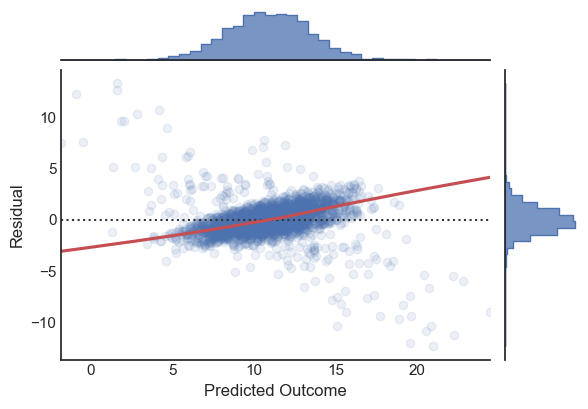

In [26]:
plt.style.use('seaborn-v0_8-white')
residPlot = sns.JointGrid(data=results_DF, x='y_pred', y='residual')
residPlot.plot_joint(sns.residplot, lowess=True, scatter_kws={'alpha': 0.1}, line_kws={'color': 'r'})
residPlot.plot_marginals(sns.histplot, element="step", bins=40)
residPlot.set_axis_labels(xlabel='Predicted Outcome', ylabel='Residual')
residPlot.fig.set_figwidth(6)
residPlot.fig.set_figheight(4)
plt.show()

### Residuals vs Features

**Age**: 
The log-transform applied to age seems to have worked out well. The residuals suggest linearity and homoscedasticity here. Other features (cell profiles) are likely the cause of the non-optimal model.


**Cell Profiles**: 
It looks like the flier/outlier values might be having a strong impact on model performance. There appears to be non-linear relationships between some of the cell profiles and the outcome. We'll try adding in higher-order polynomial terms (cubic terms) for cell profiles 2, 3, and 4, and potentially cell profile 11. This should noticeably improve the model's fit.

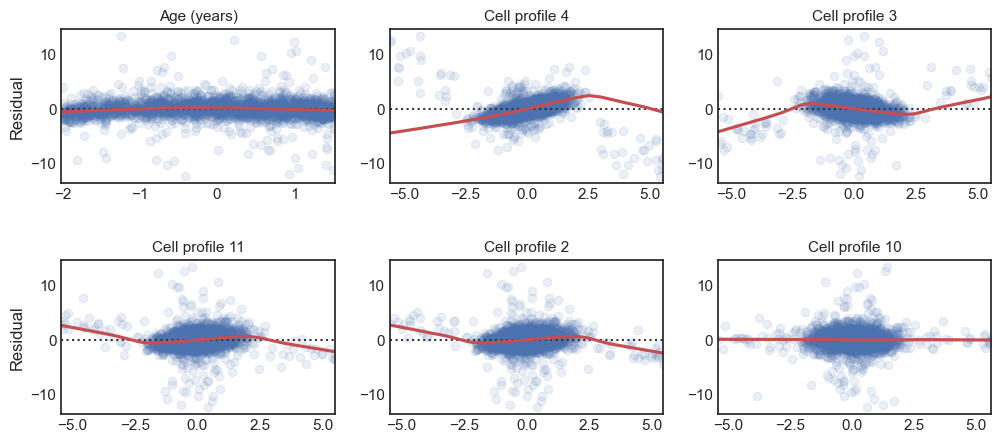

In [27]:
numericFeatures = [feature for feature in x_DF if feature not in ['Sex', 'y', 'y_pred', 'residual']]
resid_plot(results_DF, numericFeatures, y='residual', n_col=3, fig_width=12, fig_height=5, hspace=0.5, wspace=0.2)

## Non-Linear Regression Model

In [28]:
def nonlin_func(x, t0, t1, t2, t3_1, t3_2, t3_3, t4_1, t4_2, t4_3, t5_1, t5_2, t5_3, t6, t7):
    
    '''
    Non-linear function to account for non-linear relationships in linear regression model;
    Use with scipy.optimize.curve_fit
    '''
    
    # Parse out features
    x1, x2, x3, x4, x5, x6, x7 = x[:, 1], x[:, 2], x[:, 3], x[:, 4], x[:, 5], x[:, 6], x[:, 7]
    
    # Specify non-linear relationships
    # Higher order polynomials for cell profiles 4, 3 (x3, x4)
    poly_x3 = (t3_1 * x3) + (t3_2 * (x3**2)) + (t3_3 * (x3**3))
    poly_x4 = (t4_1 * x4) + (t4_2 * (x4**2)) + (t4_3 * (x4**3))
    poly_x5 = (t5_1 * x5) + (t5_2 * (x5**2)) + (t5_3 * (x5**3))
    
    # Return non-linear function
    return t0 + (t1 * x1) + (t2 * x2) + poly_x3 + poly_x4 + poly_x5 + (t6 * x6) + (t7 * x7)

# Fit non-linear regression model and extract predictions/residuals
popt, pcov = curve_fit(nonlin_func, x, y)
y_pred = nonlin_func(x, *popt)
nonlin_residuals = y - y_pred
results_DF['nonlin_pred'] = y_pred
results_DF['nonlin_resid'] = nonlin_residuals

## Non-Linear Regression Model Diagnostics

### Performance Metrics

I've read some articles suggesting that $R^2$ isn't reliable for non-linear regression. Nonetheless, it's safe to say that this model fit is an improvement on the simple OLS model, and the residual plots below confirm this.

In [29]:
# Performance metrics
print(f'MAE: {round(mean_absolute_error(y, y_pred), 2)}')
print(f'MSE: {round(mean_squared_error(y, y_pred), 2)}')
print(f'R-squared: {round(r2_score(y, y_pred), 3)}')
print(f'Adjusted R-squared: {round(r2_adj_score(y, y_pred, n=2500, k=29), 3)}')

MAE: 0.67
MSE: 0.99
R-squared: 0.904
Adjusted R-squared: 0.903


### Residuals vs Predicted Outcome

Overall, the skewness in the residuals vs predicted outcome plot is nearly resolved now. There is potentially an interesting bimodality in the residual distribution, however. I don't think this has to do with the sex variable (the distribution of the residual looks similar when stratified by sex below). It could have to do with the racial group variable that we have excluded from modeling.

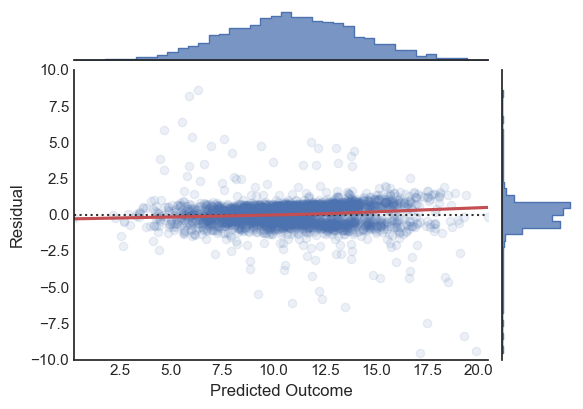

In [30]:
plt.style.use('seaborn-v0_8-white')
residPlot = sns.JointGrid(data=results_DF, x='nonlin_pred', y='nonlin_resid', ylim=(-10, 10))
residPlot.plot_joint(sns.residplot, lowess=True, scatter_kws={'alpha': 0.1}, line_kws={'color': 'r'})
residPlot.plot_marginals(sns.histplot, element="step", bins=40)
residPlot.set_axis_labels(xlabel='Predicted Outcome', ylabel='Residual')
residPlot.fig.set_figwidth(6)
residPlot.fig.set_figheight(4)
plt.show()

### Distribution of Residuals by Sex for Non-Linear Regression

<AxesSubplot: xlabel='nonlin_resid', ylabel='Count'>

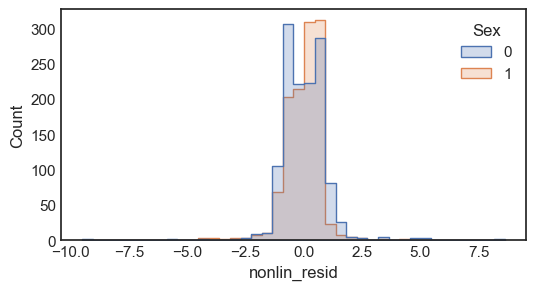

In [31]:
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.histplot(data=results_DF, x='nonlin_resid', hue='Sex', element='step', bins=40, ax=ax)

### Residuals vs Features

**Cell Profiles**: 
Residuals look much improved now that we've added in quadratic and cubic terms for cell profiles 4, 3, and 11. There was minimal improvement in model fit observed when adding in these high-order terms for cell profile 2. Overall, I'm fairly happy with the improvements we've seen here.

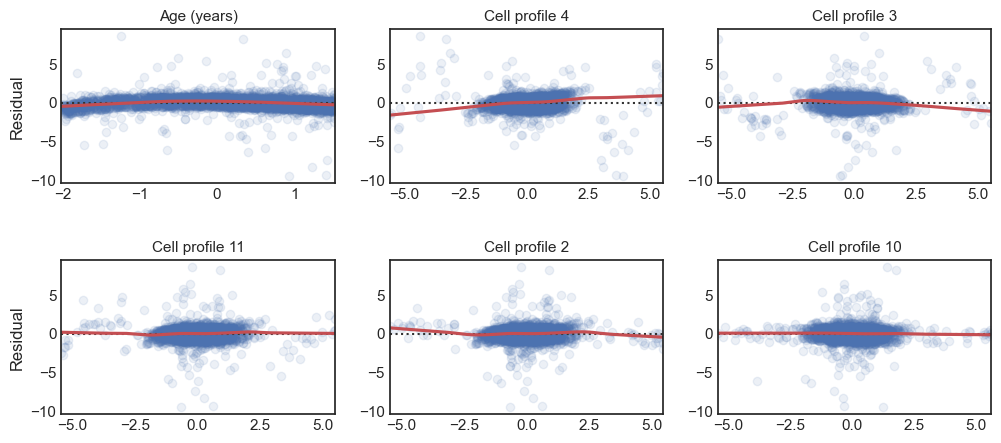

In [32]:
numericFeatures = [feat for feat in x_DF if feat not in ['Sex', 'y', 'y_pred', 'residual', 'nonlin_pred', 'nonlin_resid']]
resid_plot(results_DF, numericFeatures, y='nonlin_resid', n_col=3, fig_width=12, fig_height=5, hspace=0.5, wspace=0.2)

# Discussion

There are still improvements that can likely be made here. It might be worth it to go back and see if including racial groups (as white vs non-white) would improve model fit even further and help address the bimodality seen in the non-linear regression model residuals.